# Jupyter Notebook to Orchestrate the Strategy based on the 90% C.R
This notebook demonstrates how to use the `tilepy` package to process a skymap, obtain its 90% C.R. and decide which strategy to use 

We will:
1. Load different map types using the `MapReader` interface.
2. Create corresponding `SkyMap` objects.
3. Compute 90% containment areas.
4. Select the strategy out of `wobble`, `redundant` and `complementary`. 

In our case, the boundaries are selected as `wobble < 10 deg^2`,`redundant >10 deg^2 and <60deg^2`,  `complementary>60deg^2`

In [1]:
import healpy as hp
import numpy as np
from tilepy.include.MapManagement import MapReader, SkyMap
from tilepy.include.MapManagement.MapReader import create_map_reader
# Import main packages 
from tilepy.include.ObservationScheduler import GetSchedule, GetUniversalSchedule
from tilepy.include.PointingTools import  NextWindowTools
from tilepy.include.CampaignDefinition import ObservationParameters 
import time
import argparse
import os
from pathlib import Path
import datetime

/opt/miniconda3/envs/tilepy3/lib/python3.11/site-packages/ligo/lw/lsctables.py:89: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


# 🔵 Testing Tiling Strategy Identification with a Fermi-GBM GRB 

In [2]:
# The url to the FITS file with the sky localization in a healpix format (fits file with name starting by glg_healpix
skymapGBM ='https://heasarc.gsfc.nasa.gov/FTP/fermi/data/gbm/triggers/2024/bn240612503/current/glg_healpix_all_bn240612503_v00.fit'

# Date and time of the event in format YYYY-MM-DD HH:MM:SS. You can use 2023-07-15 14:30:10 for the example .fits file
obsTime = datetime.datetime.fromisoformat("2023-06-11 00:04:47")

# Path to the input datasets (where galaxy cat should be for GW case)
datasetDir = '../../tilepy/dataset/'

# Path to the output folder
outDir = './output'

# Config file for the tiling scheduling
cfgFile = '../config/FollowupParameters_CTAOS.ini'

# Tiles already observed
pointingsFile = None

In [3]:
# Args are parsed 
obspar_locprob = ObservationParameters()
obspar_locprob.add_parsed_args(None,obsTime,datasetDir,None,outDir,pointingsFile)
obspar_locprob.from_configfile(cfgFile)
obspar_locprob.skymap = skymapGBM
obspar_locprob.event_name = "early_gbm"


In [4]:
# Reads and manages the skymap. Obtains the 90% containment area. Let's find the most probable pixel
reader = create_map_reader(obspar_locprob)
skymap_locprob = SkyMap(obspar_locprob, reader)
size90 = skymap_locprob.getArea(0.9)
max_coord = skymap_locprob.getMaximumProbabilityCoordinates()
print(f"Max probability location: RA = {max_coord.ra.deg:.3f} deg, Dec = {max_coord.dec.deg:.3f} deg")

The filename is glg_healpix_all_bn240612503_v00.fit
The file exists, it will be re-downloaded


Max probability location: RA = 316.055 deg, Dec = 5.379 deg


In [5]:
obspar_gauss = ObservationParameters()
obspar_gauss.add_parsed_args(None,obsTime,datasetDir,None,outDir,pointingsFile)
obspar_gauss.from_configfile(cfgFile)
obspar_gauss.mode = "gaussian"
obspar_gauss.raSource = max_coord.ra.deg
obspar_gauss.decSource = max_coord.dec.deg
obspar_gauss.sigmaSource = 3.
obspar_gauss.nside = 512

reader_gauss = create_map_reader(obspar_gauss)
skymap_gauss = SkyMap(obspar_gauss, reader_gauss)


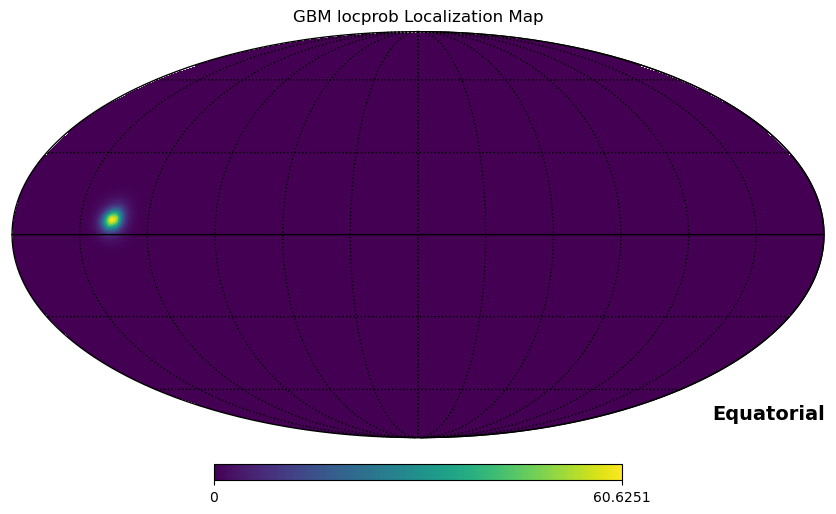

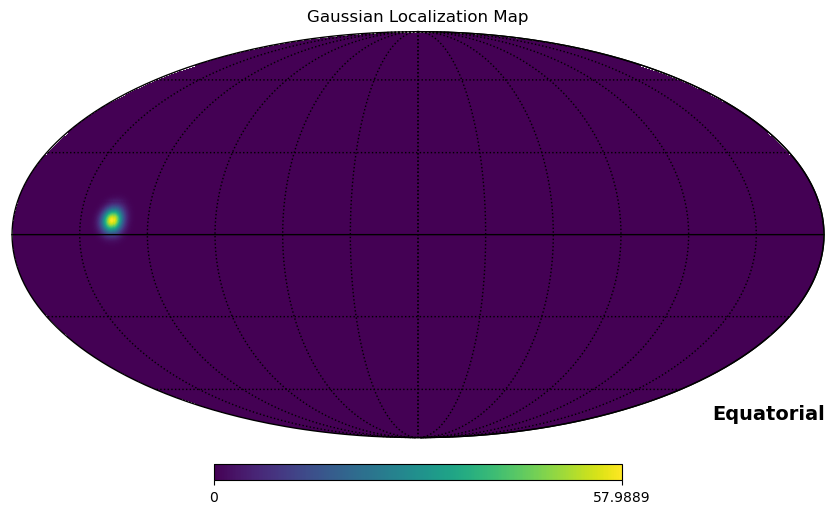

In [6]:
#Checking that it works! 
import matplotlib.pyplot as plt
hp.mollview(reader.getMap("prob").data, title="GBM locprob Localization Map",rot=[180, 0],
            coord="C",nest = True)
hp.graticule()

# Plot Gaussian Localization Map
hp.mollview(reader_gauss.getMap("prob").data, title="Gaussian Localization Map",rot=[180, 0],
            coord="C", nest = True)
hp.graticule()


In [7]:
def WobbleCoordinates(obspar):
    from astropy.coordinates import SkyCoord
    from astropy import units as u

    # Define the wobble offsets in degrees
    wobble_offsets = [ (0.4, 0), (0, 0.4), (-0.4, 0),(0, -0.4)]

    # Create a SkyCoord object for the maximum probability location
    source_coord = SkyCoord(ra=obspar.raSource, dec=obspar.decSource, unit=(u.deg, u.deg), frame='icrs')

    # Calculate the wobble positions
    wobble_positions = []
    for offset in wobble_offsets:
        delta_ra, delta_dec = offset
        wobble_coord = SkyCoord(ra=source_coord.ra + delta_ra * u.degree,
                                dec=source_coord.dec + delta_dec * u.degree,
                                frame='icrs')
        wobble_positions.append(wobble_coord)

    # Print the wobble positions
    for i, pos in enumerate(wobble_positions):
        print(f"Wobble Position {i+1}: RA = {pos.ra.deg:.3f} deg, Dec = {pos.dec.deg:.3f} deg")
    return wobble_positions


In [28]:
from astropy.io import ascii

def GetWobbleSchedule(obspar):
    """
    Generates wobble observation and visibility plots.
    
    This top level function takes the observation parameters, computes the optimal tiling
    and creates a dedicated output folder containing the scheduled pointings and optional plots.
    
    Parameters
    ----------
    obspar : ObservationParameters
        The set of parameters needed to launch the tiling scheduler.

    Returns
    -------
    None

    Notes
    -----
    If the 90% localization area is larger than the configured maximum (`locCut90`), no schedule is generated.

    Examples
    --------
    >>> GetWobbleSchedule(obspar)
    """

    raw_map = create_map_reader(obspar)
    skymap = SkyMap(obspar, raw_map)
    outputDir = "%s/%s" % (obspar.outDir, obspar.event_name)

    dirName = f"{outputDir}/Wobble"
    if not os.path.exists(dirName):
        os.makedirs(dirName)

    coordPointings = WobbleCoordinates(obspar)
    
    #Obtain the probability covered with the suggested pointings
    
    SuggestedPointings = ComputeCoveredProbability2D(coordPointings, skymap.getMap("prob", obspar.reducedNside), obspar)

    outfilename = "%s/SuggestedPointings_WobbleOptimisation.txt" % dirName
    ascii.write(
        SuggestedPointings, outfilename, overwrite=True, fast_writer=False
    )
    print()
    print(f"Resulting pointings file is {outfilename}")

    print('Now we are goint to check the times-visibility of the pointings')
    print('This is a ranking problem...')
    from tilepy.include.RankingObservationTimes import RankingTimes_2D
    RankingTimes_2D(
        obspar.obsTime,
        skymap.getMap("prob", obspar.HRnside),
        obspar,
        dirName,
        outfilename,
        obspar.obs_name,
    )

In [29]:
def ComputeCoveredProbability2D(coordPointing, prob, obspar):
    from astropy.table import Table
    import numpy as np

    nside = obspar.reducedNside
    radius = obspar.FOV

    P_GW = []
    ra_list = []
    dec_list = []
    pixlist = []
    for i, valuei in enumerate(coordPointing):
        t = 0.5 * np.pi - np.deg2rad(coordPointing[i].dec.deg)
        p = np.deg2rad(coordPointing[i].ra.deg)
        # Get the pixels for the ipix_disc (low res)
        xyz = hp.ang2vec(t, p)
        ipix_disc = hp.query_disc(nside, xyz, np.deg2rad(radius))
        effectiveipix_disc = []
        for j, valuej in enumerate(ipix_disc):
            if valuej not in pixlist:
                effectiveipix_disc.append(valuej)
            pixlist.append(valuej)
        ra_list.append(coordPointing[i].ra.deg)
        dec_list.append(coordPointing[i].dec.deg)
        P_GW.append(prob[effectiveipix_disc].sum())

    table = Table([ra_list, dec_list, P_GW], names=("RA[deg]", "DEC[deg]", 'PGW'))
    print(f"Probability covered by these pointing: {sum(P_GW)}")
    return table

# The orchestrator is here:


In [30]:
def StrategyOrchestrator(obspar, skymap, cutWobble = None, region = 0.9):
    ''' Strategy orchestrator: Decides the best pointing strategy based on the skymap size

    Inputs: obspar (ObservationParameters object), skymap (SkyMap object), cutWobble (float, in deg2, optional), region (float, proportion, optional)
    Outputs: strategy (str) 
    '''

    strategy = None  

    # Identify the number of configurations
    try:
        n = len(obspar)
        print("Number of elements:", n)
    except TypeError:
        n = 1
    
    # If cutWobble is not provided, defaults sets it to twice the FoV area of the telescope
    if cutWobble == None:
        from math import pi
        cutWobble = 2* obspar.FOV**2 * pi      # in deg2

    size = skymap_gauss.getArea(region)
    if size.value <= cutWobble:
        strategy == 'wobble'  
        print("------ STRATEGY is WOBBLE ------")
        print(f"Number of configs is {n}, the {region*100}% containment area is {size.value:.2f} deg2, CutWobble is {cutWobble:.2f} deg2")

        # Find most probable pixel
        max_coord = skymap.getMaximumProbabilityCoordinates(obspar)
        print(f"Max probability location: RA = {max_coord.ra.deg:.3f} deg, Dec = {max_coord.dec.deg:.3f} deg")
        obspar.raSource = max_coord.ra.deg
        obspar.decSource = max_coord.dec.deg
        GetWobbleSchedule(obspar)

    elif n == 1 and size.value > cutWobble:
        strategy == 'redundant'  
        print("------ STRATEGY is REDUNDANT ------")
        print(f"Number of configs is {n}, the {region*100}% containment area is {size.value:.2f} deg2, CutWobble is {cutWobble:.2f} deg2")

        GetSchedule(obspar) 
    else:
        strategy =='complementary' 
        print("------ STRATEGY is COMPLEMENTARY ------")
        print(f"Number of configs is {n}, the {region*100}% containment area is {size.value:.2f} deg2, CutWobble is {cutWobble:.2f} deg2")

        GetUniversalSchedule(obspar)
    
    

##  🚀✨ Testing the orchestrator for all cases 

In [31]:
## Wobble case
StrategyOrchestrator(obspar_gauss, skymap_locprob, cutWobble=1000)
#StrategyOrchestrator(obspar_locprob, skymap_locprob, cutWobble=1000)




------ STRATEGY is WOBBLE ------
Number of configs is 1, the 90.0% containment area is 129.95 deg2, CutWobble is 1000.00 deg2
Max probability location: RA = 316.055 deg, Dec = 5.379 deg
Wobble Position 1: RA = 316.455 deg, Dec = 5.379 deg
Wobble Position 2: RA = 316.055 deg, Dec = 5.779 deg
Wobble Position 3: RA = 315.655 deg, Dec = 5.379 deg
Wobble Position 4: RA = 316.055 deg, Dec = 4.979 deg
Probability covered by these pointing: 0.6552459887195244

Resulting pointings file is ./output/None/Wobble/SuggestedPointings_WobbleOptimisation.txt
Now we are goint to check the times-visibility of the pointings
This is a ranking problem...
Loading pointings from ./output/None/Wobble/SuggestedPointings_WobbleOptimisation.txt


ValueError: Some errors were detected !
    Line #2 (got 3 columns instead of 4)
    Line #3 (got 3 columns instead of 4)
    Line #4 (got 3 columns instead of 4)
    Line #5 (got 3 columns instead of 4)

------ STRATEGY is REDUNDANT ------
Number of configs is 1, the 90.0% containment area is 129.95 deg2, CutWobble is 1.00 deg2
Starting the 2D pointing calculation with the following parameters

Filename:  None
Date:  2023-06-11 00:04:47
Previous pointings:  None
Dataset:  ../../tilepy/dataset/
Output:  ./output/None
90% area = 129.94626141246022. 50% area = 39.145180171177074

============== Observation Parameters ======================
Observatory Name: CTAO-S
Event Name: None
obsTime: 2023-06-11 00:04:47
---------------------- Strategy ----------------------
Algorithm = 3D, Strategy = integrated,  Mangrove = False
Do Plot = True, Do Rank = True, Count Previous= True, Second Round= False, Use Grey Time= True
--------------------- Observatory ---------------------
Observatory Location: -24.5 deg, -70.17 deg, 2635.0 m
FOV: 4.0, Duration: 20.0, Min Duration: 10.0, Min Slewing: 0.0
Max Runs: 20, Max Nights: 1
Visibility: -18, -0.5, 65, 0, 0.0
Min Moon Source Separation: 30
Max Moon Source

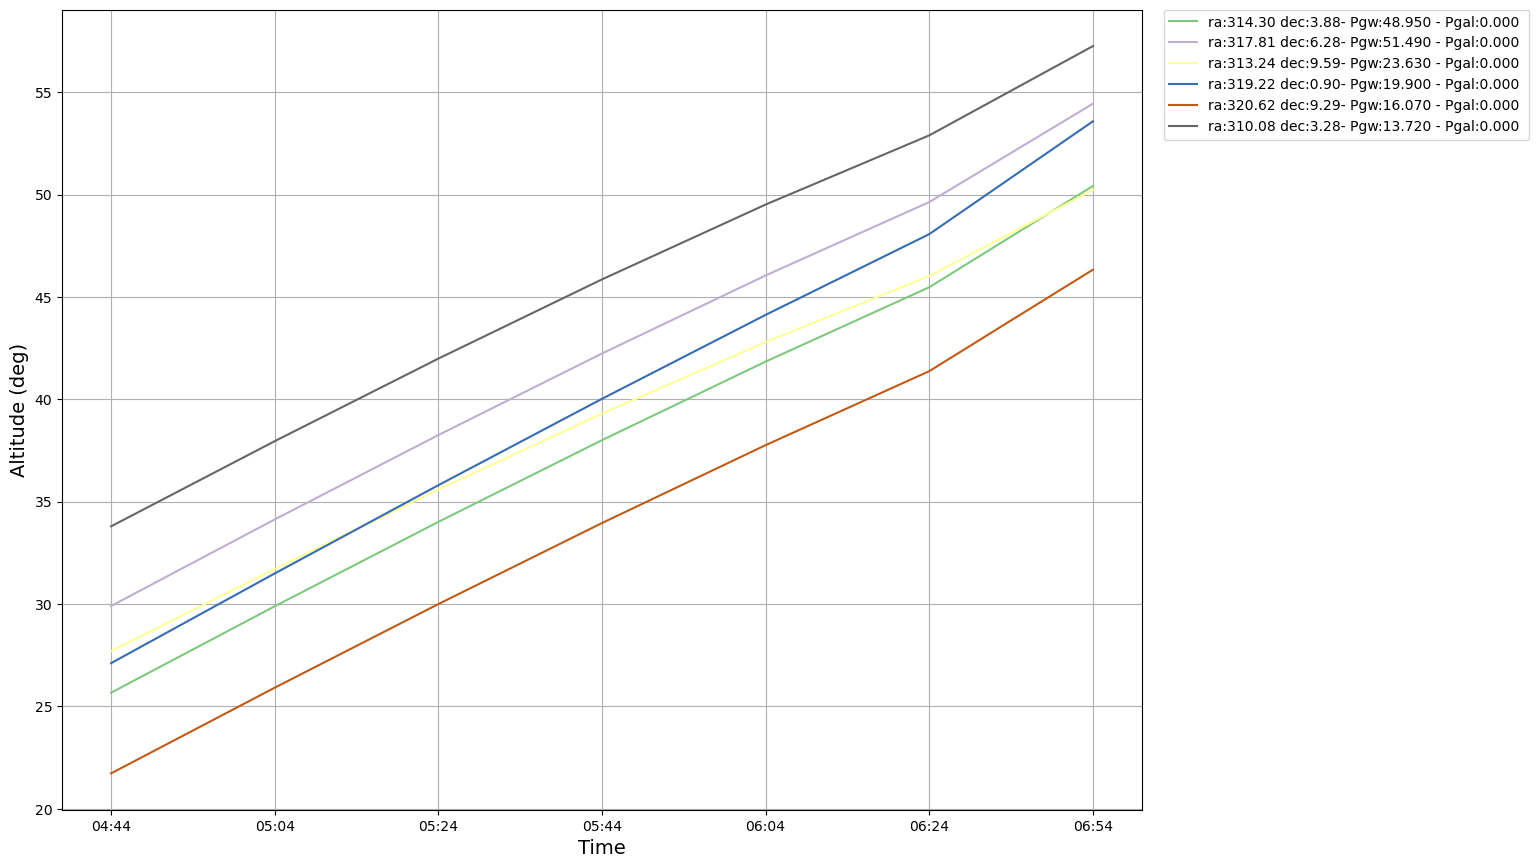

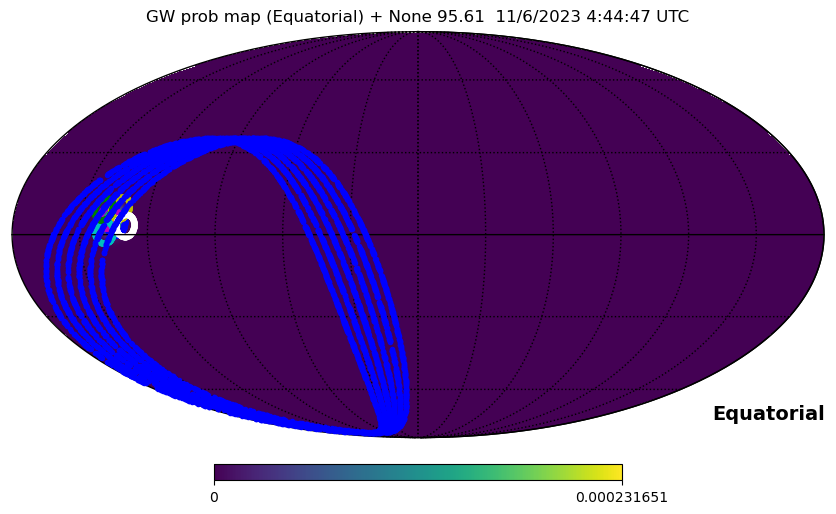

In [12]:
## Redundant case Gaussian
StrategyOrchestrator(obspar_gauss, skymap_gauss, cutWobble=1)

The filename is glg_healpix_all_bn240612503_v00.fit
The file exists, it will be re-downloaded


------ STRATEGY is REDUNDANT ------
Number of configs is 1, the 90.0% containment area is 129.95 deg2, CutWobble is 1.00 deg2
Starting the 2D pointing calculation with the following parameters

Filename:  early_gbm
Date:  2023-06-11 00:04:47
Previous pointings:  None
Dataset:  ../../tilepy/dataset/
Output:  ./output/early_gbm
90% area = 187.58212970469586. 50% area = 41.54503543795278

============== Observation Parameters ======================
Observatory Name: CTAO-S
Event Name: early_gbm
obsTime: 2023-06-11 00:04:47
---------------------- Strategy ----------------------
Algorithm = 3D, Strategy = integrated,  Mangrove = False
Do Plot = True, Do Rank = True, Count Previous= True, Second Round= False, Use Grey Time= True
--------------------- Observatory ---------------------
Observatory Location: -24.5 deg, -70.17 deg, 2635.0 m
FOV: 4.0, Duration: 20.0, Min Duration: 10.0, Min Slewing: 0.0
Max Runs: 20, Max Nights: 1
Visibility: -18, -0.5, 65, 0, 0.0
Min Moon Source Separation: 30
M

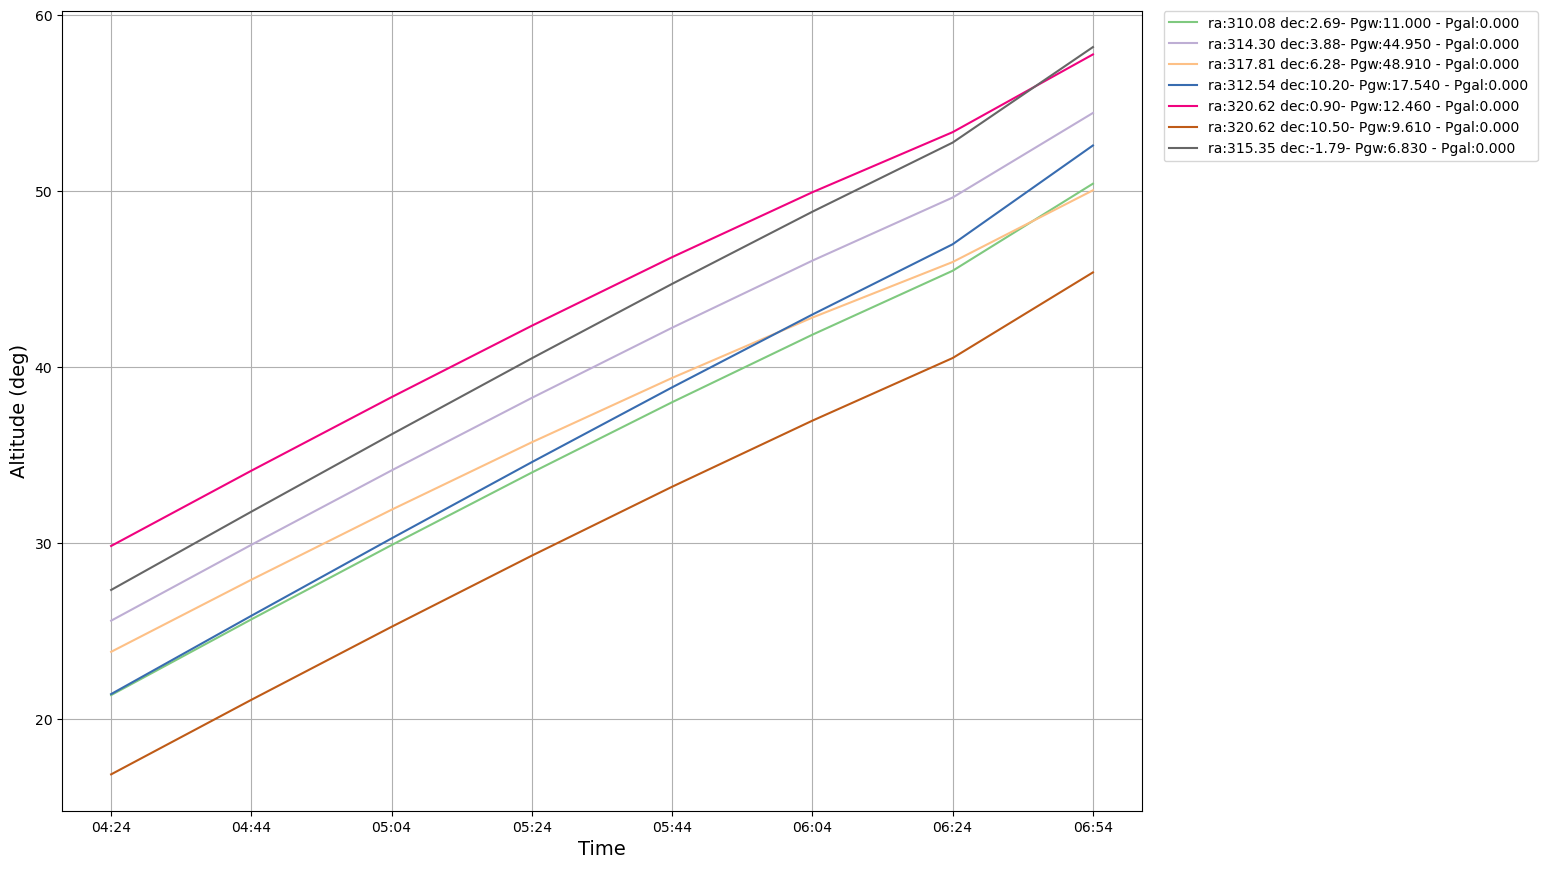

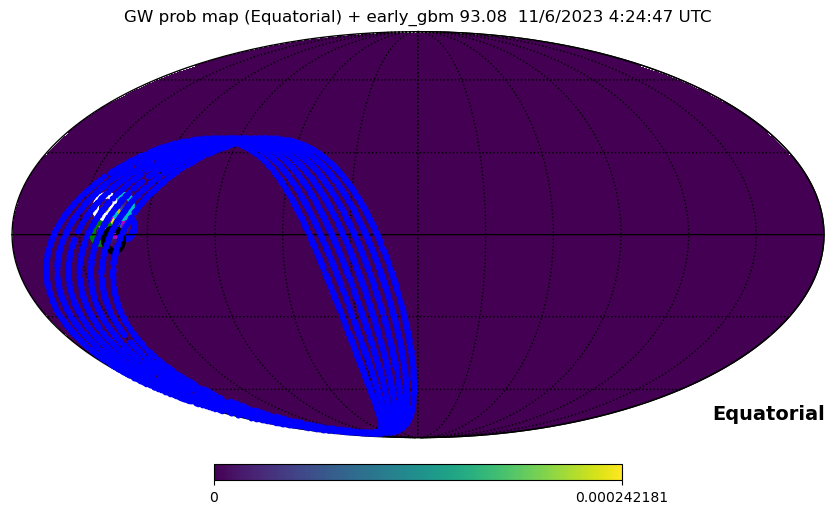

In [13]:
# Redundant case from GBM skymap
StrategyOrchestrator(obspar_locprob, skymap_locprob, cutWobble=1)

In [14]:
# Complementary case, several configurations, GBM skymap
# The url to the FITS file with the sky localization, e.g.for GW https://urlpath/Bayestar.fits.gz'
#skymap = 'https://gracedb.ligo.org/api/superevents/S190728q/files/GW190728_064510_PublicationSamples_flattened.fits.gz,0'

# Tiles already observed
pointingsFile = None
ObsArray = ['LST','MAGIC']
parameters = []

# Galaxy catalog name (if no catalog is given, the approach will be 2D) only. Path is given in datasetDir 
#galcatName = "../../tilepy/dataset/Gladeplus.h5"

# Config file for the tiling scheduling
for i in ObsArray:
    parameters.append("../config/FollowupParameters_%s.ini" % i)
print("===========================================================================================")
print('parameters', parameters)
obsparameters = []
for j in range(len(parameters)):
    obspar = ObservationParameters()
    obspar.add_parsed_args(skymapGBM, obsTime, datasetDir, None, outDir, pointingsFile)
    obspar.from_configfile(parameters[j])
    obsparameters.append(obspar)

parameters ['../config/FollowupParameters_LST.ini', '../config/FollowupParameters_MAGIC.ini']


The filename is glg_healpix_all_bn240612503_v00.fit
The file exists, it will be re-downloaded


Number of elements: 2
------ STRATEGY is COMPLEMENTARY ------
Number of configs is 2, the 90.0% containment area is 129.95 deg2, CutWobble is 10.00 deg2
Starting the 2D pointing calculation with the following parameters

Filename:  GRB240612503
Date:  2023-06-11 00:04:47
Dataset:  ../../tilepy/dataset/
Output:  ./output/GRB240612503
90% area = 187.58212970469586. 50% area = 41.54503543795278

ObservationTime0 2023-06-11 00:04:47
obsparameters 2
------NewActiveObsTime-------- LST
Observatory:  LST
Observatory:  MAGIC
Observatory:  LST
Observatory:  MAGIC
Observatory:  LST
Observatory:  MAGIC
Observatory:  LST
Observatory:  MAGIC
Observatory:  LST
Observatory:  MAGIC
The total probability PGW:  0.6794
     Time[UTC]      RA(deg)  DEC(deg)  PGW   Round ObsName Duration FoV
------------------- -------- -------- ------ ----- ------- -------- ---
2023-06-11 00:04:47 313.0664   6.8801 0.1774     1     LST     20.0 2.5
2023-06-11 00:04:47 314.6484  10.0484 0.0149     1   MAGIC     20.0 1.0
202

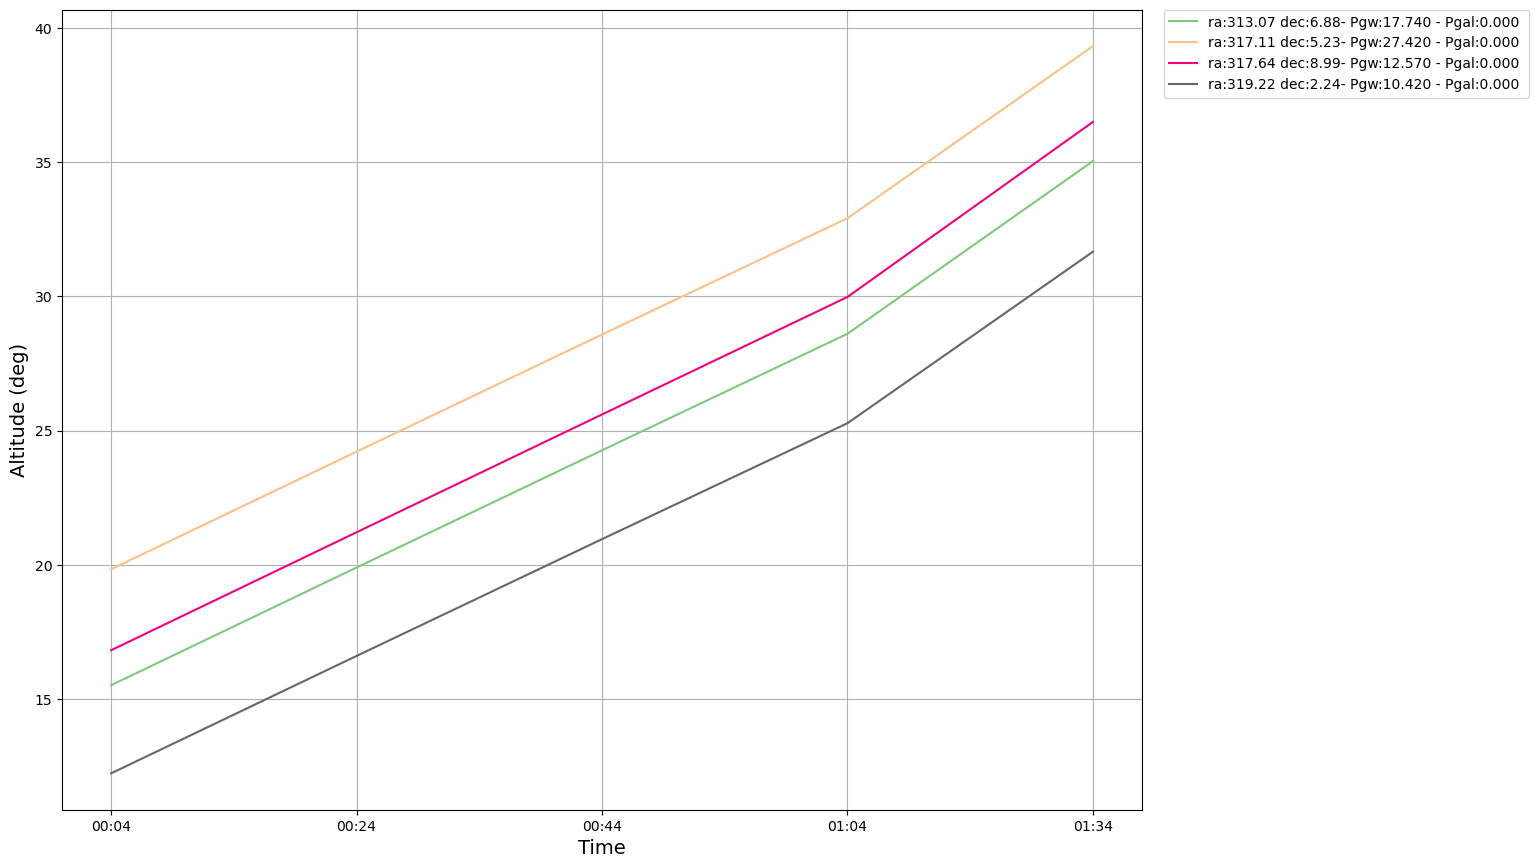

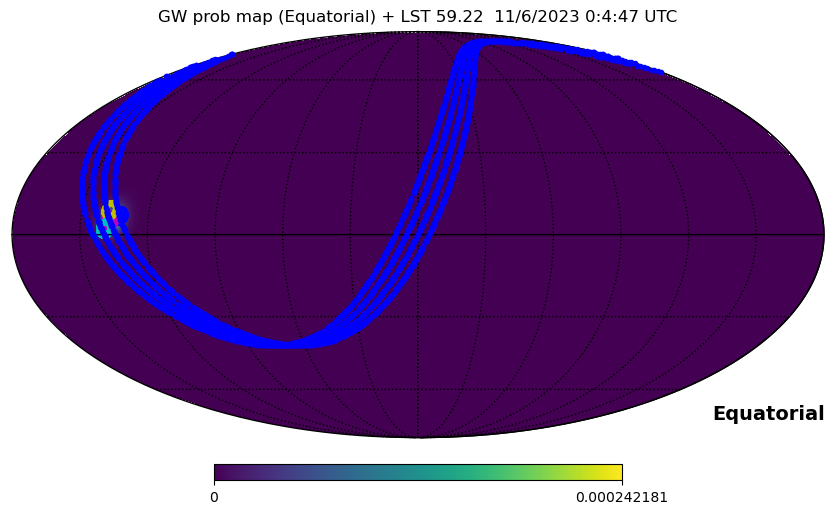

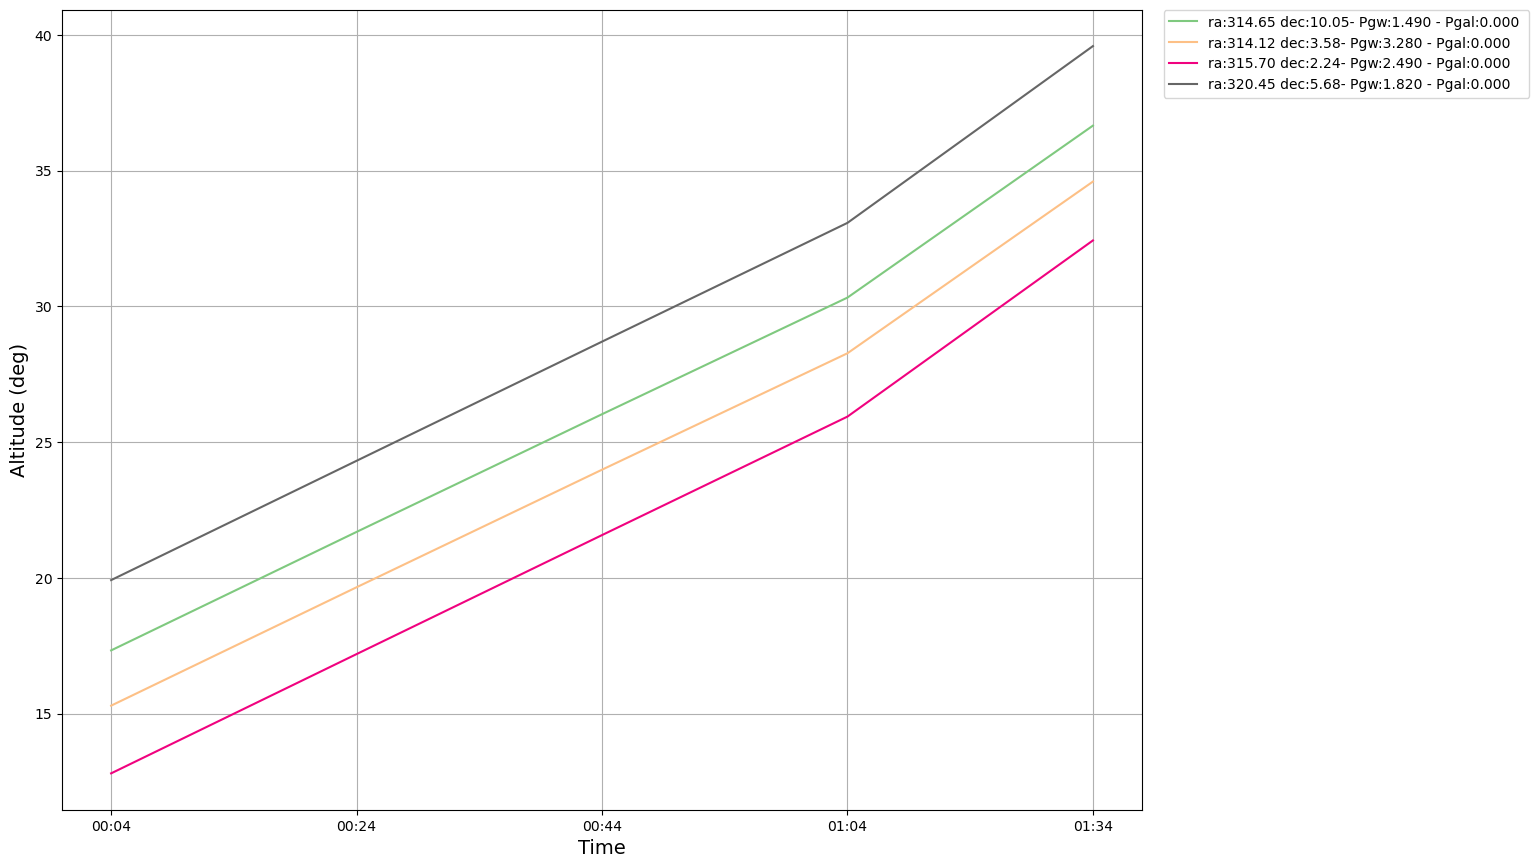

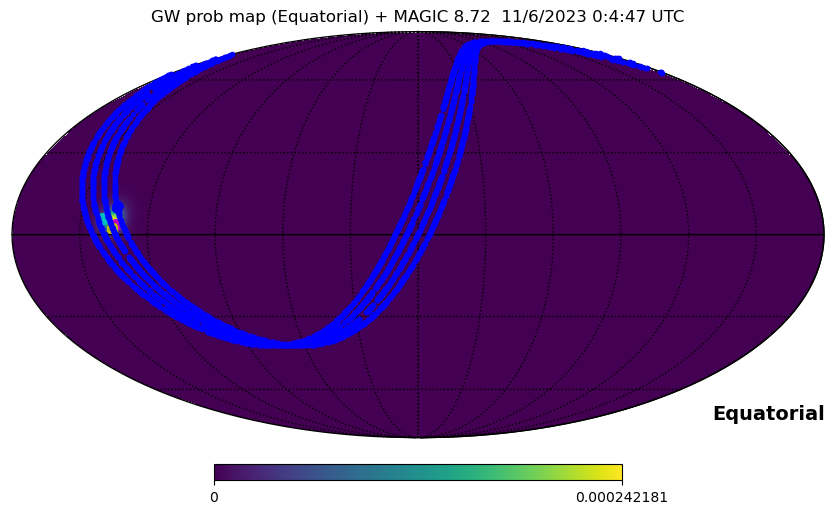

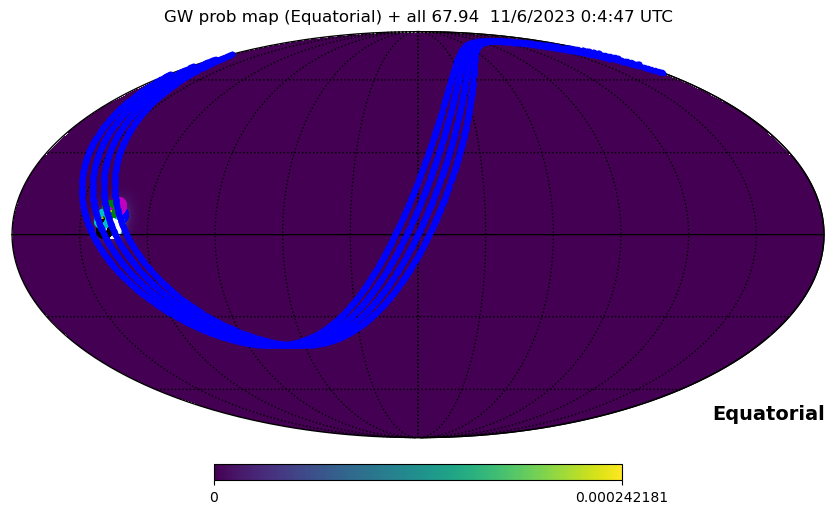

In [15]:
StrategyOrchestrator(obsparameters, skymapGBM, cutWobble=10)
